The following is a problem I ran into recently: Me and two friends live in three different countries (UK, Germany, the Netherlands) and would like to meet up sometime next year. How should we decide on where and when?

Given the high quality of public transport in Europe, any major city and any weekend would probably work out OK. Verifying this however leads to one of us opening multiple windows on a flight comparison website. In our connected, data driven world, it would be nice to believe that a better solution exists. Unfortunately I haven't found one. 

In this post I am going to look at how we might start to approach this problem using python. There isn't much new here, but we get to use a few interesting libraries and APIs.

## Problem description
Let's begin by being specific about what we hope to achieve. To keep things manageable, I am going to limit myself to air travel, and destinations in Europe. We then want to find a set of airports that
 - Have direct flights from Edinburgh, Schipol and Munich
 - Are similar flight duration and costs from each airport

## Our First Data
The best, freely available data I could find on airports comes from [Open Flights](http://openflights.org/data.html), who have collected details on Airports, Routes and Airlines in csv format and [released them](http://openflights.org/data.html#license) under the [Open Database License](http://opendatacommons.org/licenses/odbl/1.0/).

I'm not going to redistribute the data with this notebook, but if you would like to download the files to the same location I used quickly, run the folowing snippet

    !wget -P data/ https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
    !wget -P data/ https://raw.githubusercontent.com/jpatokal/openflights/master/data/airlines.dat
    !wget -P data/ https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat
    
We can now load these files, and explore them

In [1]:
# Load some standard libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

In [2]:
# load the openflight files into pandas, adding headers

airport_header = [
    'Airport_ID',
    'Name',
    'City',
    'Country',
    'IATA_FAA',
    'ICAO',
    'Latitude',
    'Longitude',
    'Altitude',
    'Timezone',
    'DST',
    'Tz_database_time_zone'
]

airports = pd.read_csv("data/airports.dat", names=airport_header)

airline_header = [
    'Airline_ID',
    'Name',
    'Alias',
    'IATA',
    'ICAO',
    'Callsign',
    'Country',
    'Active'
]

airlines = pd.read_csv("data/airlines.dat", names=airline_header)

route_header = [
    'Airline',
    'Airline_ID',
    'Source_airport',
    'Source_airport_ID',
    'Destination_airport',
    'Destination_airport_ID',
    'Codeshare',
    'Stops',
    'Equipment'
]
routes = pd.read_csv("data/routes.dat", names=route_header)

# clear up some nulls
def clean_nulls(x): return None if  x == "\\N" else np.int(x)
routes.Source_airport_ID = routes.Source_airport_ID.apply(clean_nulls)
routes.Destination_airport_ID = routes.Destination_airport_ID.apply(clean_nulls)

print("Number of Airports: {}".format(airports.shape[0]))
print("Number of Airlines: {}".format(airlines.shape[0]))
print("Number of Routes: {}".format(routes.shape[0]))


Number of Airports: 8107
Number of Airlines: 6048
Number of Routes: 67663


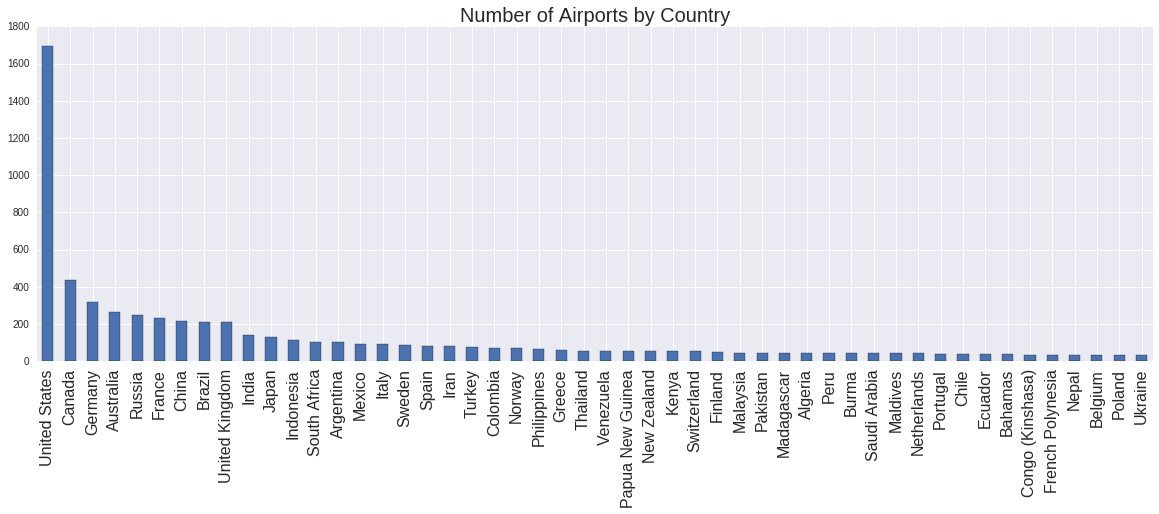

In [3]:
# Which country has the most airports?
(airports
 .Country
 .value_counts()
 [:50]
 .plot(kind="bar", figsize=(20,6)))

plt.title("Number of Airports by Country", fontsize=20)
plt.xticks(fontsize=16);

It looks like there are over 200 airports in the UK. My guess is that this means there a lot of small ones are included. Let's take a look and see what that data is showing us.

# Mapping

Given we are going to be looking at geographical data, it makes sence to try and plot the data on a map. To do this we use the [folium](https://pypi.python.org/pypi/folium) library. Folium is a python interface for the fantastic [leaflet.js](http://leafletjs.com/), a javascript library for mapping. I've found that both are excellent tools for light weight mapping. Folium is especially nice as it plays well with jupyter notebooks, and comes with a detailed set of [examples](http://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples/).

Using Folium, we can plot all the UK airports in the openflight dataset

In [4]:
import folium

map1 = folium.Map(location=[53,0], zoom_start=6)
 
for n, row in airports[airports.Country == "United Kingdom"].iterrows():
    folium.Marker(location=[row.Latitude, row.Longitude], 
                  icon=folium.Icon(color='blue'),
                  popup=row.Name).add_to(map1)

map1

We can see that the data is really detailed. It captures not just the main airports, but also small helipads, oil rigs and even a few railway stations. Other then Stoke ending up in the North Sea, it also seems pretty accurate. 

For the next step, we want to find every airport that is _reachable_ from our three starting cities. We define an airport as reachable if it has a route both too and from each of our starting cities.

In [5]:
starting_airports_iata = [
    "EDI", # edinburgh
    "AMS", # schipol
    "MUC"  # munich
]

from functools import reduce

reachable_out = (
    pd.merge(
        left=airports[airports.IATA_FAA.isin(starting_airports_iata)],
        right=routes,
        left_on="IATA_FAA",
        right_on="Source_airport")
    .groupby("Airport_ID")
    .apply(lambda df: set(df.Destination_airport.values))
)

reachable_out = reduce(lambda x,y: x & y, reachable_out.values)

reachable_in = (
    pd.merge(
        left=airports[airports.IATA_FAA.isin(starting_airports_iata)],
        right=routes,
        left_on="IATA_FAA",
        right_on="Destination_airport")
    .groupby("Airport_ID")
    .apply(lambda df: set(df.Source_airport.values))
)

reachable_in = reduce(lambda x,y: x & y, reachable_in.values)

reachable = reachable_out & reachable_in

Using the Latitude and Longitude of each airport, and remembering how [geometry works on the surface of a sphere](https://en.wikipedia.org/wiki/Haversine_formula), we can calculate the distances from each of our starting airports to the reachable airports, along with the total distance of each journey.

In [6]:
from math import asin, sin, cos, sqrt, radians

def haversine(lat1, lon1, lat2, lon2):
    """
    Returns the great circle distance between two (latitude, longitude) points
    on earth in km.
    """
    R = 6.371e3
    
    lat1r = radians(lat1)
    lat2r = radians(lat2)
    lon1r = radians(lon1)
    lon2r = radians(lon2)
    
    return R * 2 * asin(sqrt(sin((lat2r-lat1r)/2)**2 + cos(lat1r) * cos(lat2r) * sin((lon2r-lon1r)/2)**2))

reachable_airports = airports[airports.IATA_FAA.isin(reachable)].copy()

for start_point in starting_airports_iata:
    sp = airports[airports.IATA_FAA == start_point].squeeze()
    reachable_airports["distance_to_" + start_point] = (reachable_airports
                                                        .apply(lambda row: haversine(row.Latitude, row.Longitude,
                                                                                     sp.Latitude, sp.Longitude),
                                                               axis=1))
    
reachable_airports["total_distance"] =  reachable_airports[
    ["distance_to_" + start_point for start_point in starting_airports_iata]
].sum(axis=1)


With this information, we can plot the reachable airports on a map, colouring them based on their total distance

In [7]:
import matplotlib as mpl

vmin = reachable_airports.total_distance.min()
vmax = reachable_airports.total_distance.nlargest(10).iloc[-1]

norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap = plt.cm.gist_rainbow

def color_by_dist(d):
    return mpl.colors.rgb2hex(cmap(norm(d)))

In [8]:
map2 = folium.Map(location=[51,0], zoom_start=4)

for n, row in airports[airports.IATA_FAA.isin(starting_airports_iata)].iterrows():
    folium.Marker(location=[row.Latitude, row.Longitude], 
                  icon=folium.Icon(color='black'),
                  popup=row.Name).add_to(map2)

for n, row in reachable_airports.iterrows():
    folium.CircleMarker(location=[row.Latitude, row.Longitude], 
                        radius=20000, 
                        fill_opacity=1,
                        color=color_by_dist(row.total_distance),
                        fill_color=color_by_dist(row.total_distance),
                        popup=row.Name).add_to(map2)

map2

As we would expect, the closest destination (in terms of combined distance for all three of us) is Belgium, followed by Germany and other parts of central/northern Europe. 

# Flight Costs

In the previous section, we only looked at destinations reachable from all three starting cities. We still don't know the frequency of the flights, or their cost. This is not as trivial as it might sound. Finding a good API with access to flight prices is difficult if you constrain yourself to free products, and flight prices are [known to fluctuate](https://www.quora.com/What-is-the-reason-for-fluctuations-in-flight-fares-on-a-day-to-day-basis-Why-arent-they-fixed) in non-trivial ways over short time spans. 

In the end I settled on using [Skyscanners API](http://business.skyscanner.net/portal/en-GB/Documentation/ApiOverview), mostly because it was the only service I could sign up for immediate access, and even then I can only access a cached record of the cheapest flight prices by day. For our purposes, it should be enough.

Having set up a API key with Skyscanner, querying their API was straight forward, especially using their [python SDK](https://github.com/Skyscanner/skyscanner-python-sdk).

To get an estimate for the costs, I will get the cheapest flights from our three starting cities to any destination, for the month of April 2017, returning in the same month. 

(Note that prices will vary in time. If you re-run this notebook at a later date, it is likely that your prices will be different from mine)

In [9]:
import json 
from time import sleep
from skyscanner.skyscanner import FlightsCache


SKYSCANNER_API = json.load(open("api-key.json", "r"))["SKYSCANNER_API"]

flights_cache_service = FlightsCache(SKYSCANNER_API)

flight_records = {}

for iata_origin in starting_airports_iata:
    flight_records[iata_origin] = {}
    
    for iata_destination in reachable:
        sleep(0.1)
        flight_records[iata_origin][iata_destination] = flights_cache_service.get_grid_prices_by_date(
            market='UK',
            currency='EUR',
            locale='en-GB',
            originplace=iata_origin,
            destinationplace=iata_destination,
            outbounddate='2017-04',
            inbounddate='2017-04'
        ).parsed

With this information, I calculate a range of prices from each of our starting cities to each of the destinations. Given that the Skyscanner API only returns the lowest priced fair for each flight, I will take between the median and the maximum value in the range to be representative of the cost. Once I have this range, it can be plotted on the map. 

I've coloured each airport based on its maximum cost from one of our three starting locations, and added a pop-up window which shows the range of prices from each starting airport.

In [10]:
def get_price_vals(grid):
    return [p["MinPrice"] for pr in grid[1:] for p in pr[1:]
              if p is not None]


def get_price_range(grid):
    return [int(i) for i in np.percentile(get_price_vals(grid), [50,90])]

price_ranges = {
    iata_origin: {
        iata_dest: get_price_range(res["Dates"])
        for iata_dest, res in iata_dests.items()
    }
    for iata_origin, iata_dests in flight_records.items()
}

In [11]:
# create colour map
avg_prices = [p[1] for _, dest_price in price_ranges.items() for _, p in dest_price.items()]

vmin = min(avg_prices)
vmax = max(avg_prices)
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap = plt.cm.gist_rainbow

def color_by_price(p):
    return mpl.colors.rgb2hex(cmap(norm(p)))

# create geographical map
map3 = folium.Map(location=[51,0], zoom_start=4)

for n, row in airports[airports.IATA_FAA.isin(starting_airports_iata)].iterrows():
    folium.Marker(location=[row.Latitude, row.Longitude], 
                  icon=folium.Icon(color='black'),
                  popup=row.Name).add_to(map3)

for n, row in reachable_airports.iterrows():
    cost_range_edi = price_ranges["EDI"][row.IATA_FAA]
    cost_range_ams = price_ranges["AMS"][row.IATA_FAA]
    cost_range_muc = price_ranges["MUC"][row.IATA_FAA]
    
    max_avg_cost = max(cost_range_edi[1], cost_range_ams[1], cost_range_muc[1])
    
    pop_up_text = r"""
    <p>{name},</br>{city}</br><p>
    <ul>
    <li> Edinburgh €{el} - {eu} </li>
    <li> Amsterdam €{al} - {au} </li>
    <li> Munich €{ml} - {mu} </li>
    </ul>    
    """.format(name=row["Name"], city=row.City, 
               el=cost_range_edi[0], eu=cost_range_edi[1],
               al=cost_range_ams[0], au=cost_range_ams[1],
               ml=cost_range_muc[0], mu=cost_range_muc[1])

    iframe = folium.element.IFrame(html=pop_up_text, width=270, height=150)
    popup = folium.Popup(iframe)    
    
    folium.CircleMarker(location=[row.Latitude, row.Longitude], 
                        radius=20000, 
                        fill_opacity=1,
                        color=color_by_price(max_avg_cost),
                        fill_color=color_by_price(max_avg_cost),
                        popup=popup).add_to(map3)

map3

We can see that the price is fairly uniform across northern Europe. The destination with the cheapest price is London, but not by much.

And that's about all I can look at for the moment. There are a number of things that would have been interesting to look at on top of this, but unfortunately the data isn't available freely. Finding any information on flights has proven a lot more difficult then I was expecting.

The notebook used for this post can be found [here](https://github.com/ijmbarr/three-body-holiday-problem).